In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
from numpy.random import default_rng
from sklearn.linear_model import Lasso, LassoCV, LinearRegression
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
import statsmodels.api as sm
from statsmodels.api import OLS

In [2]:
ozone = pd.read_csv('ozone.csv')

# Load data
X = ozone.drop(columns=['ozone']).to_numpy()
Y = ozone['ozone'].to_numpy()

# Standardize X (centered and scaled)
scaler = StandardScaler(with_mean=True, with_std=True)
X_standardized = scaler.fit_transform(X)

# Feature names
colnames = ozone.columns[1:9]
colnames

Index(['temp', 'invHt', 'press', 'vis', 'milPress', 'hum', 'invTemp', 'wind'], dtype='object')

## Split into training, validation and test sets

In [3]:
# Set a random seed for reproducibility
rng = default_rng(1)

# Define the proportions for the split
train_prop = 0.6
validation_prop = 0.2
test_prop = 0.2

# Calculate the number of observations for each split
total_samples = ozone.shape[0]
train_size = int(train_prop * total_samples)
validation_size = int(validation_prop * total_samples)
test_size = total_samples - train_size - validation_size

# Create a random permutation of row indices
indices = rng.choice(np.arange(total_samples), size=(total_samples), replace=False)

# Split the dataset into train, validation, and test sets
y_train = Y[indices[:train_size]]
y_val = Y[indices[(train_size + 1):(train_size + validation_size)]]
y_test = Y[indices[(train_size + validation_size + 1):]]

X_train = X_standardized[indices[:train_size]]
X_val = X_standardized[indices[(train_size + 1):(train_size + validation_size)]]
X_test = X_standardized[indices[(train_size + validation_size + 1):]]

## Tuning via validation set

In [4]:
#Hyperparameter Validation for the Lasso
# Create a sequence of alpha values to try
alpha_seq = 10 ** np.linspace(-2, 0.5, num=100)

# Create empty dictionary to store the results
results = {'alpha': [], 'mse_train': [], 'mse_val': [], 'mse_test': []}

for i, alpha in enumerate(alpha_seq):
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train, y_train)

    y_train_pred = lasso.predict(X_train)
    y_val_pred = lasso.predict(X_val)
    y_test_pred = lasso.predict(X_test)

    results['alpha'].append(alpha)
    results['mse_train'].append(np.mean((y_train_pred - y_train) ** 2))
    results['mse_val'].append(np.mean((y_val_pred - y_val) ** 2))
    results['mse_test'].append(np.mean((y_test_pred - y_test) ** 2))


Best alpha: 0.464


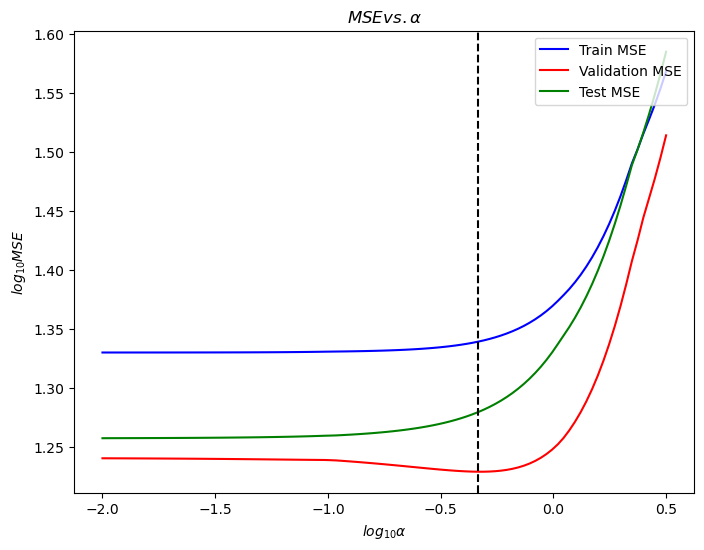

In [5]:
# Select the alpha value that minimizes the validation MSE
best_alpha = results['alpha'][np.argmin(results['mse_val'])]
print(f'Best alpha: {best_alpha:.3f}')

plt.figure(figsize=(8, 6))
plt.plot(np.log10(results['alpha']), np.log10(results['mse_train']), linestyle='-', color='blue', label='Train MSE')
plt.plot(np.log10(results['alpha']), np.log10(results['mse_val']), linestyle='-', color='red', label='Validation MSE')
plt.plot(np.log10(results['alpha']), np.log10(results['mse_test']), linestyle='-', color='green', label='Test MSE')
plt.axvline(np.log10(best_alpha), linestyle='dashed', color='black')

plt.xlabel('$log_{10} \\alpha$')
plt.ylabel('$log_{10} MSE$')
plt.title('$MSE vs. \\alpha$')
plt.legend(loc='upper right')

plt.show()

## Tuning via Cross-validation

###  K-fold Cross-Validation manually

In [6]:
n_folds = 5

# Combine validation and train sets into one (we don't need the validation set anymore)
X_train = np.vstack((X_train, X_val))
y_train = np.concatenate((y_train, y_val))

In [7]:
fold_size = int(X_train.shape[0] / n_folds)

results = {'alpha': [], 'avg_mse_cv': [], 'se_mse_cv': []}

for i, alpha in enumerate(alpha_seq):
    mse_list = []
    
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    for train_idx, val_idx in kf.split(X_train):
        lasso = Lasso(alpha=alpha)
        lasso.fit(X_train[train_idx], y_train[train_idx])
        
        y_train_pred = lasso.predict(X_train[val_idx])
        fold_mse = np.mean((y_train[val_idx] - y_train_pred) ** 2)
        mse_list.append(fold_mse)

    results['alpha'].append(alpha)
    results['avg_mse_cv'].append(np.mean(mse_list))
    results['se_mse_cv'].append(np.sqrt(np.var(mse_list)))

### Min rule

Best alpha: 0.194


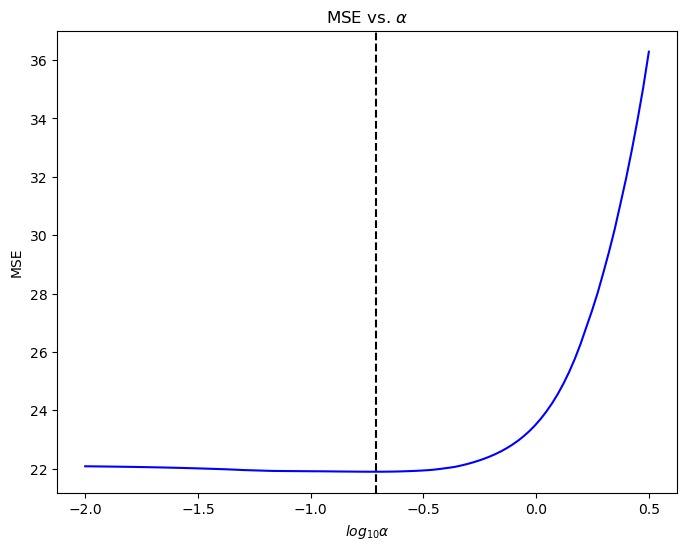

In [8]:
# Select the alpha value that minimizes the validation MSE
best_alpha = results['alpha'][np.argmin(results['avg_mse_cv'])]
print(f'Best alpha: {best_alpha:.3f}')

plt.figure(figsize=(8, 6))
plt.plot(np.log10(results['alpha']), results['avg_mse_cv'], linestyle='-', color='blue', label='Train MSE')
plt.axvline(np.log10(best_alpha), linestyle='dashed', color='black')

plt.xlabel('$log_{10} \\alpha$')
plt.ylabel('MSE')
plt.title('MSE vs. $\\alpha$')

plt.show()

### 1 SE rule

1 SE Rule alpha: 0.988


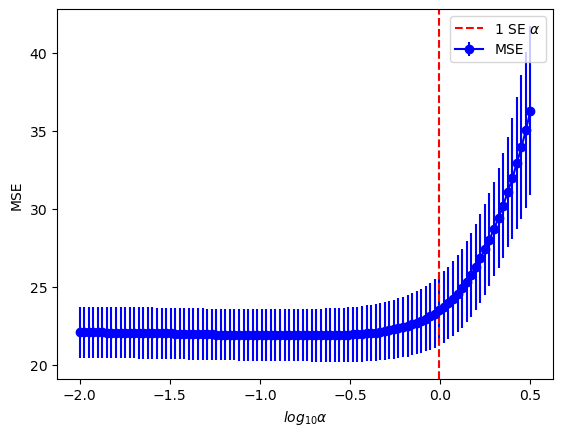

In [9]:
# Select the alpha within 1SE of the minimum (1 SE Rule)
best_mse_idx = np.argmin(results['avg_mse_cv'])
threshold = results['avg_mse_cv'][best_mse_idx] + results['se_mse_cv'][best_mse_idx]
one_se_alpha = np.max(np.array(results['alpha'])[results['avg_mse_cv'] < threshold])

print(f'1 SE Rule alpha: {one_se_alpha:.3f}')

# Plot MSE with error bars
plt.errorbar(np.log10(results['alpha']), results['avg_mse_cv'], yerr=results['se_mse_cv'], fmt='b-o', label='MSE')
plt.axvline(np.log10(one_se_alpha), color='red', linestyle='--', label='1 SE $\\alpha$')
plt.xlabel('$log_{10} \\alpha$')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [10]:
# What is the sparsity of these models?
min_lasso_model = Lasso(alpha=best_alpha)
one_se_lasso_model = Lasso(alpha=one_se_alpha)
min_lasso_model.fit(X_train, y_train)
one_se_lasso_model.fit(X_train, y_train)

coef_comparison = np.column_stack((colnames,min_lasso_model.coef_, one_se_lasso_model.coef_))
print("Coefficients comparison:")
print(pd.DataFrame(coef_comparison, columns=["Feature","Min alpha", "1 SE Rule alpha"]))

Coefficients comparison:
    Feature Min alpha 1 SE Rule alpha
0      temp  3.943832        3.758067
1     invHt  -1.44258       -1.152569
2     press  0.052043             0.0
3       vis -0.173132            -0.0
4  milPress       0.0             0.0
5       hum  1.337682        0.833357
6   invTemp  0.808185        0.541995
7      wind       0.0             0.0


### CV using `LassoCV`

Min alpha: 0.260
1 SE alpha: 1.485


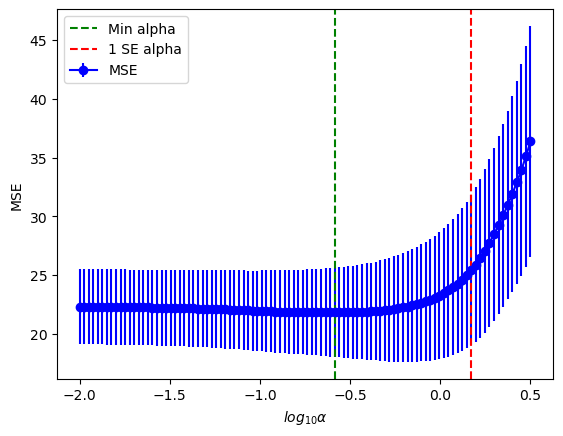

In [11]:
lasso_cv = LassoCV(alphas=alpha_seq,  cv=n_folds)
lasso_cv.fit(X_train, y_train)

# Extract min alpha and 1-SE alpha
min_alpha_5_folds = lasso_cv.alpha_
print(f'Min alpha: {min_alpha_5_folds:.3f}')

mse_path_mean = np.mean(lasso_cv.mse_path_, axis=1)
mse_path_std = np.std(lasso_cv.mse_path_, axis=1)
thresh = mse_path_mean[np.argmin(mse_path_mean)] + mse_path_std[np.argmin(mse_path_mean)]
one_se_alpha_5_folds = np.max(lasso_cv.alphas_[mse_path_mean <= thresh])
print(f'1 SE alpha: {one_se_alpha_5_folds:.3f}')

plt.errorbar(np.log10(lasso_cv.alphas_), mse_path_mean, yerr=mse_path_std, fmt='b-o', label='MSE')
plt.axvline(np.log10(min_alpha_5_folds), color='green', linestyle='--', label='Min alpha')
plt.axvline(np.log10(one_se_alpha_5_folds), color='red', linestyle='--', label='1 SE alpha')
plt.xlabel('$log_{10} \\alpha$')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [12]:
# What is the sparsity of these models?
min_lasso_model = Lasso(alpha=min_alpha_5_folds)
one_se_lasso_model = Lasso(alpha=one_se_alpha_5_folds)
min_lasso_model.fit(X_train, y_train)
one_se_lasso_model.fit(X_train, y_train)


coef_comparison = np.column_stack((colnames,min_lasso_model.coef_, one_se_lasso_model.coef_))
print("Coefficients comparison:")
print(pd.DataFrame(coef_comparison, columns=["Feature","Min alpha", "1 SE Rule alpha"]))

Coefficients comparison:
    Feature Min alpha 1 SE Rule alpha
0      temp  3.968478        3.630031
1     invHt -1.433232       -0.956197
2     press       0.0             0.0
3       vis -0.142742            -0.0
4  milPress       0.0             0.0
5       hum  1.326747        0.466883
6   invTemp  0.736354        0.363809
7      wind       0.0             0.0


## Validating Interpretations: Stability

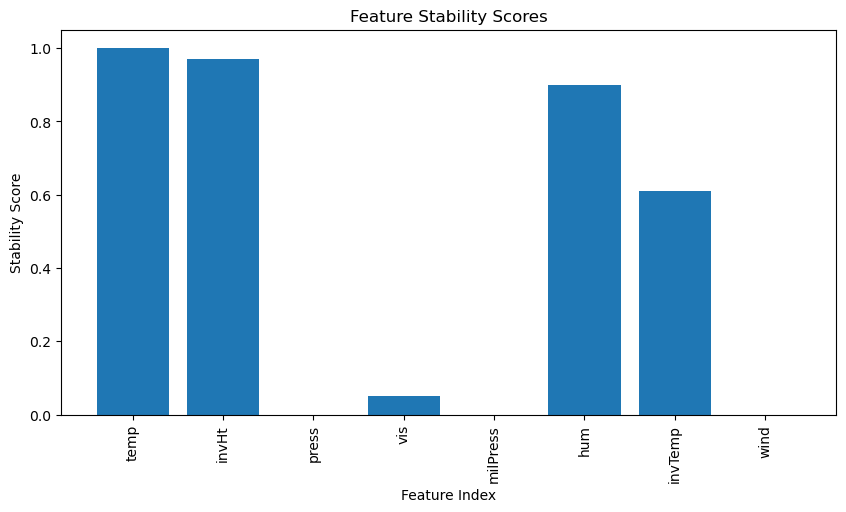

In [13]:
num_sim = 200
train_size = int(0.5 * X_train.shape[0])
stability_scores = np.zeros(X_train.shape[1])

for n in range(num_sim):
    train_idx = rng.choice(X_train.shape[0], train_size, replace=False)
    X_train_sample = X_train[train_idx]
    y_train_sample = y_train[train_idx]
    
    lasso = Lasso(alpha=one_se_alpha_5_folds)
    lasso.fit(X_train_sample, y_train_sample)
    stability_scores += (lasso.coef_ != 0)

stability_scores /= num_sim

# Plot stability scores
plt.figure(figsize=(10, 5))
plt.bar(colnames, stability_scores)
plt.ylabel('Stability Score')
plt.xlabel('Feature Index')
plt.xticks(rotation=90)
plt.title('Feature Stability Scores')
plt.show()

## Validating Interpretations: Generalizability

In [14]:
# Evaluate models selected by stability using the Test Set
# Evaluate models with varying stability score thresholds
mse_per_model = {'num_features': [], 'mse': []}
scores = np.sort(np.unique(stability_scores))[::-1]

for score in scores:
    score_filter = stability_scores >= score
    
    if np.sum(score_filter) == 0:
        continue
    
    # Fit a Lasso model with the features that have a stability score >= score
    lasso = Lasso(alpha=one_se_alpha_5_folds)
    lasso.fit(X_train[:, score_filter], y_train)
    y_pred = lasso.predict(X_test[:, score_filter])
    mse = np.mean((y_test - y_pred) ** 2)
    mse_per_model['num_features'].append(np.sum(score_filter))
    mse_per_model['mse'].append(mse)

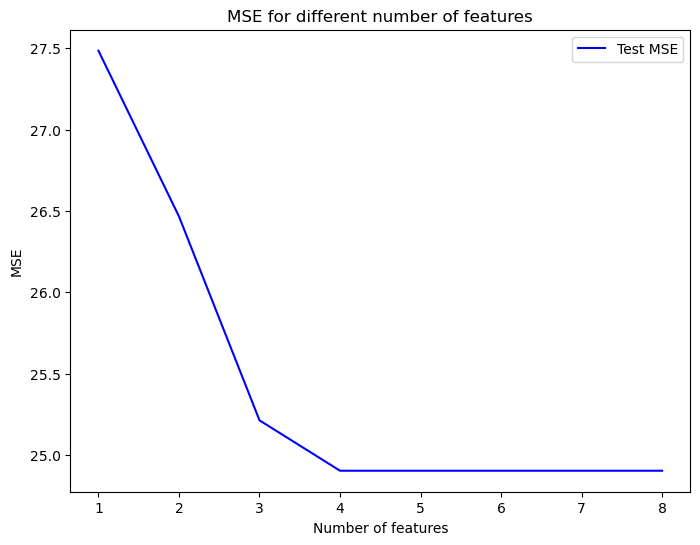

In [15]:
# Plot the MSE as a function of the number of features
plt.figure(figsize=(8, 6))
plt.plot(mse_per_model['num_features'], mse_per_model['mse'], linestyle='-', color='blue', label='Test MSE')

plt.xlabel('Number of features')
plt.ylabel('MSE')
plt.title('MSE for different number of features')
plt.legend(loc='upper right')

plt.show()

In [16]:
# Select model via stability and evaluate significance of OLS fit on Test Set
score_filter = stability_scores >= scores[3]

xt_train = sm.add_constant(X_train[:, score_filter])


# Fit OLS of the selected model on the training set
lsmodel = OLS(y_train,xt_train).fit()
lsmodel.summary()

#ols = LinearRegression()
#ols.fit(X_train[:, score_filter], y_train)
#y_pred = ols.predict(X_test[:, score_filter])
#mse = np.mean((y_test - y_pred) ** 2)
#print(f'MSE for test set least squares solution {mse:.3f}')
#print(f"Previous lowest test MSE from Lasso {mse_per_model['mse'][3]:.3f}")

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.674
Model:                            OLS   Adj. R-squared:                  0.669
Method:                 Least Squares   F-statistic:                     133.6
Date:                Mon, 17 Feb 2025   Prob (F-statistic):           1.19e-61
Time:                        09:22:23   Log-Likelihood:                -769.44
No. Observations:                 263   AIC:                             1549.
Df Residuals:                     258   BIC:                             1567.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.6856      0.281     41.538      0.000      11.132      12.240
x1             4.0109      0.705      5.690      0.000       2.623       5.399
x2            -1.5419      0.531     -2.901      0.004      -2.588      -0.495
x3             1.5633      0.322      4.853      0.000       0.929       2.198
x4             0.8997      0.937      0.961      0.338      -0.945       2.744
==============================================================================
Omnibus:                        2.648   Durbin-Watson:                   2.166
Prob(Omnibus):                  0.266   Jarque-Bera (JB):                2.446
Skew:                           0.234   Prob(JB):                        0.294
Kurtosis:                       3.061   Cond. No.                         6.90
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""